In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))

from main import simulate_planes, knots_to_nm_per_min, eta_minutes

In [15]:
# --- Utilidades Monte Carlo para promediar gráficos ---
from main import simulate_planes
import numpy as np

def montecarlo_planes(lambda_prob, total_minutes, n_mc=1000):
    """
    Ejecuta n_mc simulaciones y retorna una lista de listas de aviones.
    """
    all_planes = []
    for _ in range(n_mc):
        planes, _ = simulate_planes(lambda_prob, total_minutes)
        all_planes.append(planes)
    return all_planes

# Ejemplo de uso para graficar promedios Monte Carlo:
# all_planes = montecarlo_planes(0.15, 1080, n_mc=1000)
# Luego adaptar cada función de gráfico para aceptar all_planes y promediar.


In [32]:
def run_complete_analysis(lambda_prob=0.15, total_minutes=1080, n_mc=1000, show_animation=False):
    """
    Ejecuta un análisis completo con todas las visualizaciones usando Monte Carlo.
    Args:
        lambda_prob: Probabilidad de aparición de aeronaves
        total_minutes: Duración de la simulación
        n_mc: Caminos Monte Carlo
        show_animation: Si mostrar la animación (puede ser lenta)
    """
    print(f"Ejecutando simulación completa con λ = {lambda_prob}")
    print(f"Duración: {total_minutes} minutos ({total_minutes/60:.1f} horas)")
    print(f"Caminos Monte Carlo: {n_mc}")
    print("-" * 60)
    # Ejecutar Monte Carlo
    all_planes = montecarlo_planes(lambda_prob, total_minutes, n_mc=n_mc)
    # Estadísticas básicas promedio
    total_planes = sum(len(planes) for planes in all_planes)
    landed = sum(len([p for p in planes if p.status == 'landed']) for planes in all_planes)
    montevideo = sum(len([p for p in planes if p.status == 'montevideo']) for planes in all_planes)
    en_aproximacion = sum(len([p for p in planes if p.status == 'approaching' and p.dist > 0]) for planes in all_planes)
    print(f"Total de aviones simulados: {total_planes//n_mc}")
    print(f"Aterrizados: {landed//n_mc} ({landed/total_planes*100:.1f}%)")
    print(f"Se fueron a Montevideo: {montevideo//n_mc} ({montevideo/total_planes*100:.1f}%)")
    print(f"En aproximación al final: {en_aproximacion//n_mc}")
    print("-" * 60)

In [34]:
run_complete_analysis(lambda_prob=0.16355, total_minutes=1080, n_mc=1000)

Ejecutando simulación completa con λ = 0.16355
Duración: 1080 minutos (18.0 horas)
Caminos Monte Carlo: 1000
------------------------------------------------------------
Total de aviones simulados: 176
Aterrizados: 95 (54.3%)
Se fueron a Montevideo: 78 (44.4%)
En aproximación al final: 2
------------------------------------------------------------


In [ ]:
def plot_landing_times_bar_mc(all_planes):
    """
    Histograma promedio de horarios de aterrizaje usando Monte Carlo.
    Args:
        all_planes: lista de listas de objetos Plane (cada lista es un camino MC)
    """
    horas_all = []
    total_landed = 0
    for planes in all_planes:
        landed = [p for p in planes if p.status == 'landed' and p.landed_time is not None]
        horas = [6 + (p.landed_time // 60) for p in landed]
        horas_all.extend(horas)
        total_landed += len(landed)
    n_mc = len(all_planes)
    # Histograma absoluto
    counts, bins = np.histogram(horas_all, bins=range(6, 25))
    # Promedio por avión
    avg_counts = counts / total_landed if total_landed > 0 else counts
    plt.figure(figsize=(12, 6))
    plt.bar(range(6, 24), avg_counts, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xlabel('Hora de aterrizaje', fontsize=12)
    plt.ylabel('Proporción de aterrizajes', fontsize=12)
    plt.title('Distribución promedio de aterrizajes por hora (Monte Carlo, proporción)', fontsize=14)
    plt.xticks(range(6, 25))
    plt.grid(True, alpha=0.3)
    for i, v in enumerate(avg_counts):
        if v > 0:
            plt.text(i + 6, v + 0.001, f'{v:.2f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()


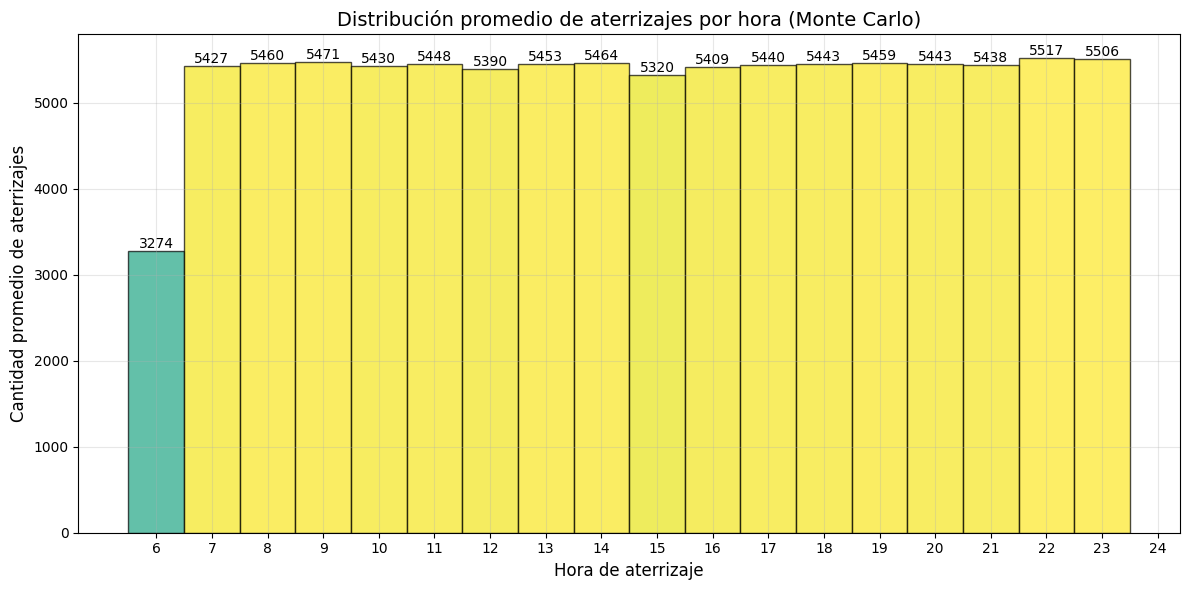

In [40]:
plot_landing_times_bar_mc(all_planes)

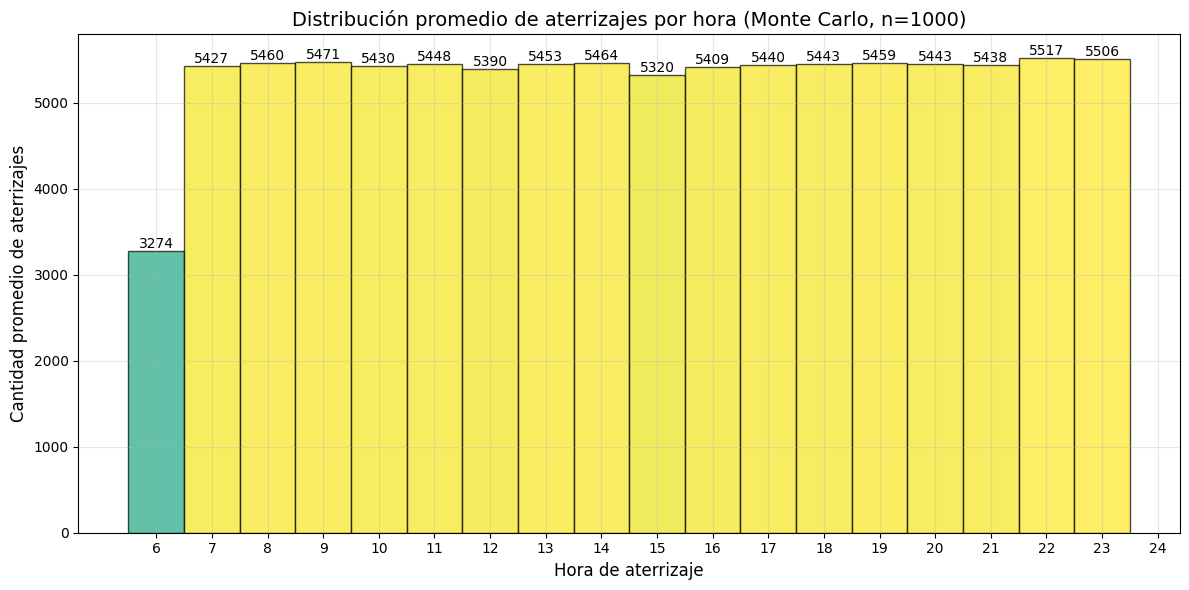

In [20]:
# Ejecutar 1000 caminos Monte Carlo y graficar promedios de aterrizajes por hora
lambda_prob = 0.16355
n_mc = 1000
total_minutes = 1080
all_planes = montecarlo_planes(lambda_prob, total_minutes, n_mc=n_mc)

def plot_landing_times_bar_mc(all_planes):
    """
    Histograma promedio de horarios de aterrizaje usando Monte Carlo.
    """
    horas_all = []
    for planes in all_planes:
        landed = [p for p in planes if p.status == 'landed' and p.landed_time is not None]
        horas = [6 + (p.landed_time // 60) for p in landed]
        horas_all.extend(horas)
    plt.figure(figsize=(12, 6))
    n, bins, patches = plt.hist(horas_all, bins=range(6, 25), color='skyblue', edgecolor='black', align='left', alpha=0.7)
    colors = cm.viridis(n / max(n))
    for patch, color in zip(patches, colors):
        patch.set_facecolor(color)
    plt.xlabel('Hora de aterrizaje', fontsize=12)
    plt.ylabel('Cantidad promedio de aterrizajes', fontsize=12)
    plt.title(f'Distribución promedio de aterrizajes por hora (Monte Carlo, n={n_mc})', fontsize=14)
    plt.xticks(range(6, 25))
    plt.grid(True, alpha=0.3)
    for i, v in enumerate(n):
        if v > 0:
            plt.text(i + 6, v + 0.1, str(int(v)), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

plot_landing_times_bar_mc(all_planes)


In [ ]:
def plot_delay_analysis(planes):
    """
    Analiza y grafica los atrasos de las aeronaves.
    
    Args:
        planes: Lista de objetos Plane de la simulación
    """
    landed = [p for p in planes if p.status == 'landed' and p.landed_time is not None]
    if not landed:
        print("No hay aviones aterrizados para analizar atrasos")
        return
    
    def baseline_time_from_100nm():
        """Tiempo teórico mínimo desde 100mn sin congestión"""
        t = 50/(300/60) + 35/(250/60) + 10/(200/60) + 5/(150/60)
        return t
    
    baseline = baseline_time_from_100nm()
    delays = [(p.landed_time - p.appear_time) - baseline for p in landed]
    appear_times = [p.appear_time for p in landed]
    
    # Solo un histograma de atrasos
    plt.figure(figsize=(10, 6))
    plt.hist(delays, bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
    plt.xlabel('Atraso (minutos)', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.title('Distribución de atrasos', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.axvline(x=np.mean(delays), color='red', linestyle='--', 
                label=f'Promedio: {np.mean(delays):.1f} min')
    plt.legend()
    plt.tight_layout()
    plt.show()


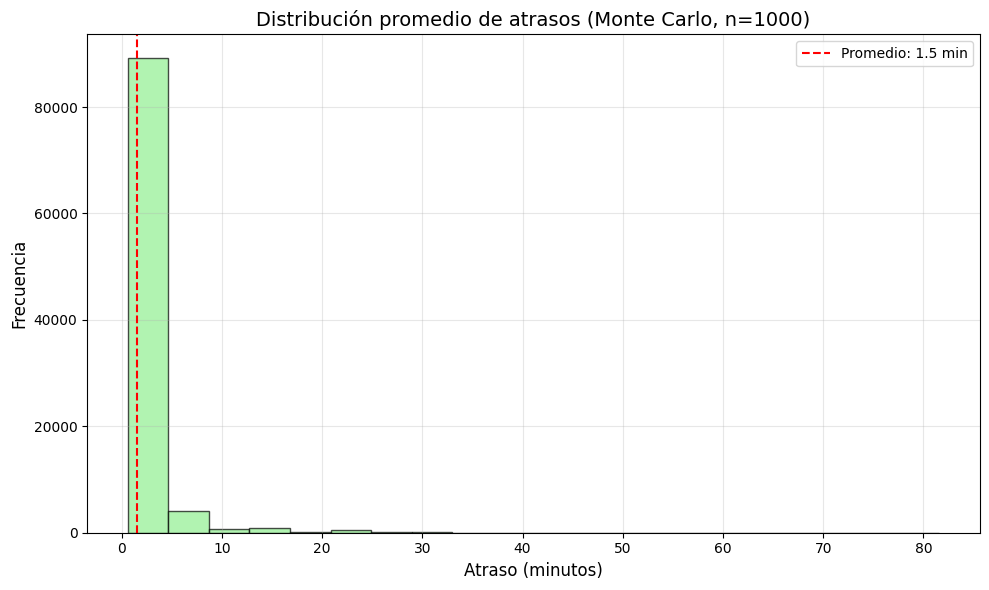

In [24]:
# Análisis de atrasos promedio con Monte Carlo

def plot_delay_analysis_mc(all_planes):
    """
    Analiza y grafica los atrasos promedio de las aeronaves usando Monte Carlo.
    """
    delays_all = []
    def baseline_time_from_100nm():
        t = 50/(300/60) + 35/(250/60) + 10/(200/60) + 5/(150/60)
        return t
    baseline = baseline_time_from_100nm()
    for planes in all_planes:
        landed = [p for p in planes if p.status == 'landed' and p.landed_time is not None]
        delays = [(p.landed_time - p.appear_time) - baseline for p in landed]
        delays_all.extend(delays)
    plt.figure(figsize=(10, 6))
    plt.hist(delays_all, bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
    plt.xlabel('Atraso (minutos)', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.title(f'Distribución promedio de atrasos (Monte Carlo, n={n_mc})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.axvline(x=np.mean(delays_all), color='red', linestyle='--', label=f'Promedio: {np.mean(delays_all):.1f} min')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_delay_analysis_mc(all_planes)


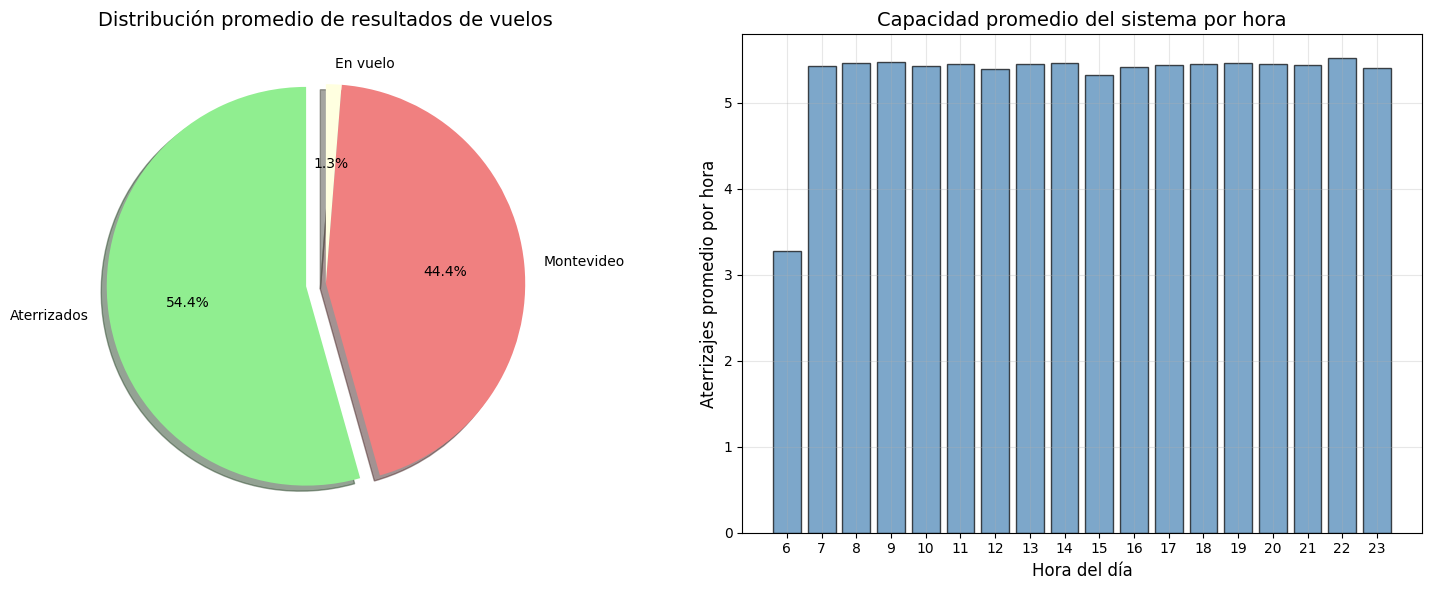

In [29]:
# Eficiencia promedio del sistema con Monte Carlo

def plot_system_efficiency_mc(all_planes):
    """
    Gráfica métricas de eficiencia promedio del sistema usando Monte Carlo.
    """
    landed_total = 0
    montevideo_total = 0
    in_flight_total = 0
    landings_per_hour_all = []
    for planes in all_planes:
        landed = len([p for p in planes if p.status == 'landed'])
        montevideo = len([p for p in planes if p.status == 'montevideo'])
        in_flight = len([p for p in planes if p.status == 'approaching'])
        landed_planes = [p for p in planes if p.status == 'landed' and p.landed_time is not None]
        landed_total += landed
        montevideo_total += montevideo
        in_flight_total += in_flight
        # Por hora
        hours = range(6, 24)
        landings_per_hour = []
        for hour in hours:
            count = len([p for p in landed_planes if hour <= (6 + p.landed_time // 60) < hour + 1])
            landings_per_hour.append(count)
        landings_per_hour_all.append(landings_per_hour)
    # Promedios
    n_mc = len(all_planes)
    landed_avg = landed_total / n_mc
    montevideo_avg = montevideo_total / n_mc
    in_flight_avg = in_flight_total / n_mc
    landings_per_hour_avg = np.mean(landings_per_hour_all, axis=0)
    # Gráfico de torta
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    labels = ['Aterrizados', 'Montevideo', 'En vuelo']
    sizes = [landed_avg, montevideo_avg, in_flight_avg]
    colors = ['lightgreen', 'lightcoral', 'lightyellow']
    explode = (0.1, 0, 0)
    ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.set_title('Distribución promedio de resultados de vuelos', fontsize=14)
    # Eficiencia por hora
    hours = range(6, 24)
    ax2.bar(hours, landings_per_hour_avg, color='steelblue', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Hora del día', fontsize=12)
    ax2.set_ylabel('Aterrizajes promedio por hora', fontsize=12)
    ax2.set_title('Capacidad promedio del sistema por hora', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(hours)
    plt.tight_layout()
    plt.show()

plot_system_efficiency_mc(all_planes)
